<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_ARIMA_otsoniennustamiseen_(v3_Korjattu_ennustus).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- ARIMA Ozone Forecasting Script (Univariate - v3) ---

Ladataan otsonidataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv
Lukeminen CSV:stä (käyttäen Kallio-spesifiä logiikkaa: iso-8859-1, sep=,, dec=,, skip=1)...
Otsonidatan lataus onnistui.
Muunnettu 'Otsoni [µg/m³]' numeroksi.
Luodaan Timestamp...
Poistettu 663 riviä NaN Timestamp/Otsoni -arvojen vuoksi.
Palautetaan DataFrame, muoto: (43180, 1)
Timestamp luotu, indeksi asetettu, duplikaatit poistettu.

Tarkistetaan ladattu DataFrame...
DataFrame OK, jatketaan mallinnukseen.

Ladattu 43180 riviä otsonidataa.

--- 2. Stationarisuuden tarkistus ---
Käytetään differoinnin astetta d=0 (perustuen aiempaan ADF-testiin).

--- 3. ARIMA-järjestyksen (p, d, q) määrittäminen (käytetään d=0) ---
Käytetään placeholder ARIMA-järjestystä: p=2, d=0, q=1

--- 4. Datan jako opetus- ja testijoukkoihin ---
Opetusdata: 2020-

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA-malli sovitettu.

--- 6. Ennusteiden tekeminen testijaksolle ---
Ennustetaan numeerisilla indekseillä: start=38862, end=43179


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Ennusteiden indeksi muutettu aikaleimoiksi.

--- 7. Mallin evaluointi ---
Test RMSE: 16.194
Test MAE: 12.644


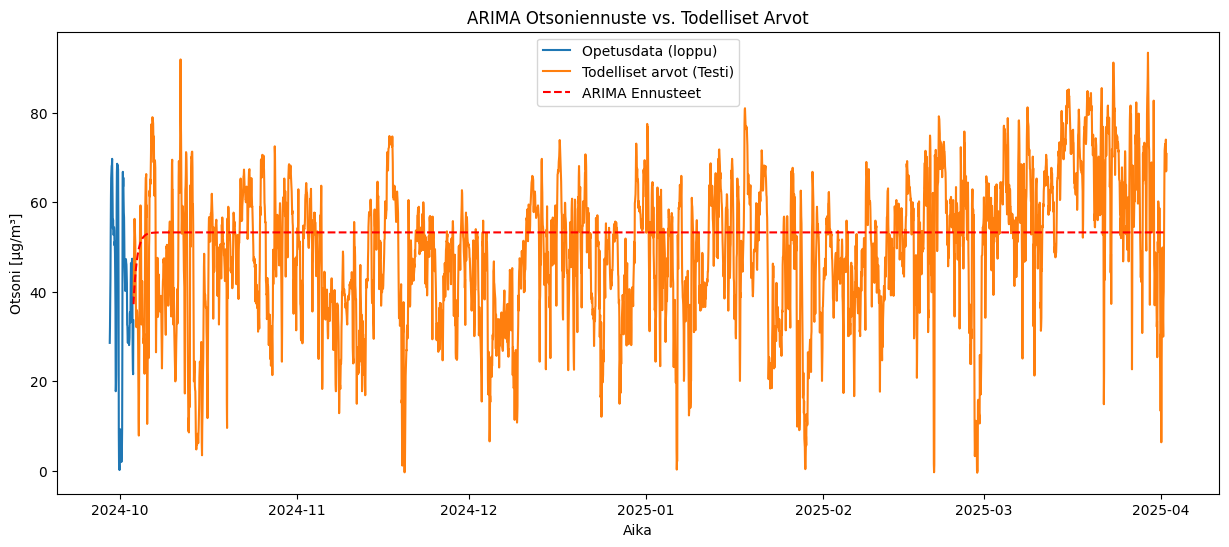


--- 8. Piikkien päätteleminen ennusteista (valinnainen) ---
Käytetään piikin kynnysarvoa (opetusdatan 90. persentiili): 77.90

ARIMA Piikkiennusteiden (päätelty) evaluointi:
Ei voitu laskea luokitteluraporttia (testidatassa tai ennusteissa vain yhtä luokkaa).
Todellisia piikkejä testidatassa: 105
Ennustettuja piikkejä: 0

--- ARIMA-skripti päättyi ---


In [1]:
# -*- coding: utf-8 -*-
"""
Colab Script for ARIMA Ozone Forecasting (Helsinki Kallio) - v3

Loads Kallio ozone data, checks stationarity, fits an ARIMA model,
makes predictions using correct indexing, and evaluates.
NOTE: This is a univariate model and does NOT use weather data.
"""

# Kirjastojen tuonti
import pandas as pd
import numpy as np
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback

# Aikasarja-analyysikirjastot
from statsmodels.tsa.stattools import adfuller # Stationarisuustestiin
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # p ja q arviointiin
from statsmodels.tsa.arima.model import ARIMA # ARIMA-malli
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from math import sqrt

print("--- ARIMA Ozone Forecasting Script (Univariate - v3) ---")

# --- Funktio datan lataamiseen ja peruspuhdistukseen (Otsoni) ---
def load_and_clean_ozone_data(raw_url):
    """Lataa ja esikäsittelee otsonidatan annetusta URL:sta."""
    print(f"\nLadataan otsonidataa: {raw_url}")
    df_local = None
    try:
        response = requests.get(raw_url)
        response.raise_for_status()
        print("Lukeminen CSV:stä (käyttäen Kallio-spesifiä logiikkaa: iso-8859-1, sep=,, dec=,, skip=1)...")
        csv_content = io.StringIO(response.content.decode('iso-8859-1'))
        column_names_ozone = ["Havaintoasema", "Vuosi", "Kuukausi", "Päivä", "Aika [Paikallinen aika]", "Otsoni [µg/m³]"]
        df_local = pd.read_csv(
             csv_content, sep=',', decimal=',', skiprows=1, header=None,
             names=column_names_ozone, quoting=csv.QUOTE_NONNUMERIC, low_memory=False
        )
        print("Otsonidatan lataus onnistui.")

        o3_col = "Otsoni [µg/m³]"
        if o3_col in df_local.columns:
             df_local[o3_col] = pd.to_numeric(df_local[o3_col], errors='coerce')
             print(f"Muunnettu '{o3_col}' numeroksi.")
        else:
             print(f"Virhe: Otsonisarake '{o3_col}' ei löytynyt.")
             return None

        print("Luodaan Timestamp...")
        year_col, month_col, day_col, time_col = 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]'
        required_dt_cols = [year_col, month_col, day_col, time_col]
        if not all(col in df_local.columns for col in required_dt_cols):
             print(f"Virhe: Aikaleiman luontiin vaadittavia sarakkeita puuttuu: {required_dt_cols}")
             return None

        df_local[year_col] = pd.to_numeric(df_local[year_col], errors='coerce').astype('Int64')
        df_local[month_col] = pd.to_numeric(df_local[month_col], errors='coerce').astype('Int64')
        df_local[day_col] = pd.to_numeric(df_local[day_col], errors='coerce').astype('Int64')
        if df_local[required_dt_cols].isnull().any().any():
             print("Varoitus: Puuttuvia arvoja päivämäärä/aikakomponenteissa ennen yhdistämistä.")
             df_local.dropna(subset=required_dt_cols, inplace=True)

        df_local[year_col] = df_local[year_col].astype(str)
        df_local[month_col] = df_local[month_col].astype(str).str.zfill(2)
        df_local[day_col] = df_local[day_col].astype(str).str.zfill(2)
        df_local[time_col] = df_local[time_col].astype(str)
        time_str = df_local[time_col].str.replace('24:00', '00:00', regex=False)
        datetime_str = df_local[year_col] + '-' + df_local[month_col] + '-' + df_local[day_col] + ' ' + time_str
        df_local['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce')
        df_local.loc[df_local[time_col] == '24:00', 'Timestamp'] += pd.Timedelta(days=1)

        initial_rows_before_dropna = len(df_local)
        df_local.dropna(subset=['Timestamp', o3_col], inplace=True)
        print(f"Poistettu {initial_rows_before_dropna - len(df_local)} riviä NaN Timestamp/Otsoni -arvojen vuoksi.")

        df_local = df_local[['Timestamp', o3_col]].copy()
        df_local.set_index('Timestamp', inplace=True)
        df_local.sort_index(inplace=True)

        duplicates = df_local.index.duplicated(keep='first')
        num_duplicates = duplicates.sum()
        if num_duplicates > 0:
            print(f"Poistetaan {num_duplicates} duplikaatti-indeksiä.")
            df_local = df_local[~duplicates]

        print(f"Palautetaan DataFrame, muoto: {df_local.shape}")
        if df_local.empty:
            print("VAROITUS: Palautettava DataFrame on tyhjä!")
        # else:
            # print("DataFrame head ennen palautusta:") # Less verbose
            # print(df_local.head())

        print("Timestamp luotu, indeksi asetettu, duplikaatit poistettu.")
        return df_local

    except requests.exceptions.RequestException as e:
        print(f"Virhe datan haussa URL:sta: {e}")
        return None
    except Exception as e:
        print(f"Virhe datan käsittelyssä: {e}")
        traceback.print_exc()
        return None

# --- 1. Datan lataus ---
ozone_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv"
df_ozone = load_and_clean_ozone_data(ozone_url)

print("\nTarkistetaan ladattu DataFrame...")
if df_ozone is not None and not df_ozone.empty:
    print("DataFrame OK, jatketaan mallinnukseen.")
    o3_col = "Otsoni [µg/m³]"
    print(f"\nLadattu {len(df_ozone)} riviä otsonidataa.")

    # --- 2. Stationarisuuden tarkistus ---
    print("\n--- 2. Stationarisuuden tarkistus ---")
    # (Visualisointi ja testi ajettiin aiemmin, oletetaan tulos)
    # Aiempi tulos: Todennäköisesti stationaarinen, d=0
    d = 0
    print(f"Käytetään differoinnin astetta d={d} (perustuen aiempaan ADF-testiin).")

    # --- 3. ARIMA-järjestyksen (p, d, q) määrittäminen ---
    print(f"\n--- 3. ARIMA-järjestyksen (p, d, q) määrittäminen (käytetään d={d}) ---")
    # (ACF/PACF-kuvaajat piirrettiin aiemmin)
    # Käytetään placeholder-arvoja - MUOKKAA NÄITÄ TARVITTAESSA
    p = 2 # Placeholder
    q = 1 # Placeholder
    print(f"Käytetään placeholder ARIMA-järjestystä: p={p}, d={d}, q={q}")
    arima_order = (p, d, q)

    # --- 4. Datan jako opetus- ja testijoukkoihin ---
    print("\n--- 4. Datan jako opetus- ja testijoukkoihin ---")
    test_size = 0.1
    split_index = int(len(df_ozone) * (1 - test_size))
    train_data = df_ozone[o3_col].iloc[:split_index]
    test_data = df_ozone[o3_col].iloc[split_index:]
    print(f"Opetusdata: {train_data.index.min()} - {train_data.index.max()} ({len(train_data)} riviä)")
    print(f"Testidata: {test_data.index.min()} - {test_data.index.max()} ({len(test_data)} riviä)")

    # --- 5. ARIMA-mallin sovittaminen ---
    print("\n--- 5. ARIMA-mallin sovittaminen opetusdataan ---")
    arima_result = None
    try:
        # Lisätään taajuus indeksiin, jos mahdollista (voi auttaa ennustamisessa)
        # train_data_freq = train_data.asfreq('H') # Kokeile asettaa tuntitaajuus
        # Jos yllä oleva aiheuttaa virheitä tai NaN, käytä alkuperäistä:
        train_data_freq = train_data

        arima_model = ARIMA(train_data_freq, order=arima_order)
        arima_result = arima_model.fit()
        print("ARIMA-malli sovitettu.")
        # print(arima_result.summary()) # Vähemmän tulostetta oletuksena
    except Exception as e_fit:
        print(f"Virhe ARIMA-mallin sovittamisessa: {e_fit}")
        traceback.print_exc()

    # --- 6. Ennusteiden tekeminen ---
    if arima_result:
        print("\n--- 6. Ennusteiden tekeminen testijaksolle ---")
        try:
            # *** KORJATTU PREDICT-KUTSU ***
            # Käytetään numeerisia indeksejä suhteessa alkuperäisen datan kokoon
            n_train = len(train_data)
            n_total = len(df_ozone) # Koko datan pituus ennen jakoa
            start_pred_loc = n_train
            end_pred_loc = n_total - 1 # Indeksi alkaa nollasta

            print(f"Ennustetaan numeerisilla indekseillä: start={start_pred_loc}, end={end_pred_loc}")

            # predict-metodi palauttaa Seriesin numeerisella indeksillä
            predictions_arima_numeric = arima_result.predict(start=start_pred_loc, end=end_pred_loc)

            # Muunnetaan ennusteiden indeksi vastaamaan testidatan aikaleimaindeksiä
            if len(predictions_arima_numeric) == len(test_data):
                 predictions_arima = pd.Series(predictions_arima_numeric.values, index=test_data.index)
                 print("Ennusteiden indeksi muutettu aikaleimoiksi.")
            else:
                 print(f"Varoitus: Ennusteiden ({len(predictions_arima_numeric)}) ja testidatan ({len(test_data)}) pituudet eivät täsmää!")
                 # Yritetään silti, mutta voi aiheuttaa virheitä myöhemmin
                 predictions_arima = pd.Series(predictions_arima_numeric.values[:len(test_data)], index=test_data.index)


            # --- 7. Evaluointi ---
            print("\n--- 7. Mallin evaluointi ---")
            try:
                rmse = sqrt(mean_squared_error(test_data, predictions_arima))
                mae = mean_absolute_error(test_data, predictions_arima)
                print(f'Test RMSE: {rmse:.3f}')
                print(f'Test MAE: {mae:.3f}')

                plt.figure(figsize=(15, 6))
                plt.plot(train_data.index[-100:], train_data[-100:], label='Opetusdata (loppu)')
                plt.plot(test_data.index, test_data, label='Todelliset arvot (Testi)')
                plt.plot(predictions_arima.index, predictions_arima, label='ARIMA Ennusteet', color='red', linestyle='--')
                plt.title('ARIMA Otsoniennuste vs. Todelliset Arvot')
                plt.xlabel('Aika')
                plt.ylabel(o3_col)
                plt.legend()
                plt.show()

                # --- 8. Piikkien päätteleminen (valinnainen) ---
                print("\n--- 8. Piikkien päätteleminen ennusteista (valinnainen) ---")
                try:
                    spike_threshold_train = train_data.quantile(0.90)
                    print(f"Käytetään piikin kynnysarvoa (opetusdatan 90. persentiili): {spike_threshold_train:.2f}")
                    predicted_spikes_arima = (predictions_arima > spike_threshold_train).astype(int)
                    actual_spikes_test = (test_data > spike_threshold_train).astype(int)

                    print("\nARIMA Piikkiennusteiden (päätelty) evaluointi:")
                    if len(np.unique(actual_spikes_test)) > 1 and len(np.unique(predicted_spikes_arima)) > 1:
                         print(classification_report(actual_spikes_test, predicted_spikes_arima))
                         print("Confusion Matrix:")
                         print(confusion_matrix(actual_spikes_test, predicted_spikes_arima))
                    else:
                         print("Ei voitu laskea luokitteluraporttia (testidatassa tai ennusteissa vain yhtä luokkaa).")
                         print(f"Todellisia piikkejä testidatassa: {actual_spikes_test.sum()}")
                         print(f"Ennustettuja piikkejä: {predicted_spikes_arima.sum()}")
                except Exception as e_spike:
                    print(f"Virhe piikkien päättelemisessä: {e_spike}")

            except Exception as e_eval:
                print(f"Virhe evaluoinnissa: {e_eval}")

        except Exception as e_pred:
            print(f"Virhe ennusteiden tekemisessä: {e_pred}")
            traceback.print_exc() # Tulosta koko traceback ennustusvirheestä

    else: # arima_result is None
        print("\nEi voitu tehdä ennusteita, koska mallin sovitus epäonnistui.")

else: # df_ozone is None or empty
    print("\nEi voitu jatkaa mallinnukseen, koska datan lataus epäonnistui tai data on tyhjä.")


print("\n--- ARIMA-skripti päättyi ---")